In [3]:
import pandas as pd
df  = pd.read_csv('data.csv')
print(df.head())

   0.000  0.640  0.640.1  0.000.1  0.320  0.000.2  0.000.3  0.000.4  0.000.5  \
0   0.21   0.28     0.50      0.0   0.14     0.28     0.21     0.07     0.00   
1   0.06   0.00     0.71      0.0   1.23     0.19     0.19     0.12     0.64   
2   0.00   0.00     0.00      0.0   0.63     0.00     0.31     0.63     0.31   
3   0.00   0.00     0.00      0.0   0.63     0.00     0.31     0.63     0.31   
4   0.00   0.00     0.00      0.0   1.85     0.00     0.00     1.85     0.00   

   0.000.6  ...  0.000.816  0.000.817  0.000.818  0.000.819  0.000.820  \
0     0.94  ...       0.00        0.0        0.0       0.00       0.00   
1     0.25  ...       0.06        0.0        0.0       0.12       0.06   
2     0.63  ...       0.00        0.0        0.0       0.00       0.00   
3     0.63  ...       0.00        0.0        0.0       0.00       0.00   
4     0.00  ...       0.00        0.0        0.0       0.00       0.00   

   0.000.821  0.000.822  0.000.823  0.000.824  1  
0       0.00       0.00

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Columns: 1186 entries, 0.000 to 1
dtypes: float64(1185), int64(1)
memory usage: 41.6 MB
None


In [11]:
print(df.isnull().sum())

0.000        0
0.640        0
0.640.1      0
0.000.1      0
0.320        0
            ..
0.000.821    0
0.000.822    0
0.000.823    0
0.000.824    0
1            0
Length: 1186, dtype: int64


In [13]:
print(df.describe())

             0.000        0.640      0.640.1      0.000.1        0.320  \
count  4600.000000  4600.000000  4600.000000  4600.000000  4600.000000   
mean      0.104576     0.212922     0.280578     0.065439     0.312222   
std       0.305387     1.290700     0.504170     1.395303     0.672586   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.420000     0.000000     0.382500   
max       4.540000    14.280000     5.100000    42.810000    10.000000   

           0.000.2      0.000.3      0.000.4      0.000.5      0.000.6  ...  \
count  4600.000000  4600.000000  4600.000000  4600.000000  4600.000000  ...   
mean      0.095922     0.114233     0.105317     0.090087     0.239465  ...   
std       0.273850     0.391480     0.401112     0.278643     0.644816  ...   
min       0.00000

In [6]:
label_counts = df.iloc[:, -1].value_counts() 

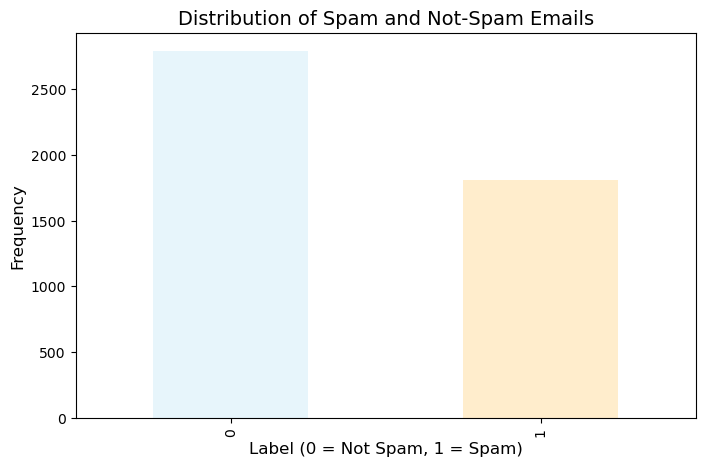

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.2)
plt.title('Distribution of Spam and Not-Spam Emails', fontsize=14)
plt.xlabel('Label (0 = Not Spam, 1 = Spam)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()



In [38]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.iloc[:,:-1].values # All columns accept the last one
y = df.iloc[:,-1].values # Last column as labels

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#split into trian and test
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify splits
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (2760, 1185)
Testing set size: (920, 1185)


In [67]:
import copy
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def reduced_error_pruning(decision_tree, X_val, y_val):
    """
    Perform iterative bottom-up Reduced Error Pruning (REP) on a trained DecisionTreeClassifier
    using validation data (X_val, y_val).
    
    Parameters:
    -----------
    decision_tree : DecisionTreeClassifier (already fit)
    X_val         : Validation features
    y_val         : Validation labels
    
    Returns:
    --------
    pruned_tree   : A new DecisionTreeClassifier object that has been pruned
    """
    # Make a deep copy so we don't affect the original tree
    pruned_tree = copy.deepcopy(decision_tree)
    
    # We will keep pruning while we observe an improvement on the validation set
    # in at least one node during a full pass. If no improvements occur in a pass,
    # we stop.
    improved = True
    current_accuracy = accuracy_score(y_val, pruned_tree.predict(X_val))

    while improved:
        improved = False
        # We'll collect pruning candidates (node_id -> possible_accuracy_if_pruned)
        # Then pick the best improvement in a single pass.
        candidates = []
        
        # The structure of the tree is found in pruned_tree.tree_
        # We can iterate over all nodes in the tree
        tree_ = pruned_tree.tree_
        for node_id in range(tree_.node_count):
            left_child = tree_.children_left[node_id]
            right_child = tree_.children_right[node_id]

            # Only consider internal nodes (i.e., nodes that have children)
            if left_child == -1 or right_child == -1:
                continue

            # Temporarily prune this node by turning it into a leaf
            # Save original children pointers
            original_left = left_child
            original_right = right_child

            # Optionally, save the original value if you plan to recalc
            original_value = tree_.value[node_id].copy()

            # Optionally compute the sum of children distributions 
            # to make it a more accurate leaf.
            combined_value = tree_.value[original_left] + tree_.value[original_right]

            # Prune
            tree_.children_left[node_id] = -1
            tree_.children_right[node_id] = -1
            # Optionally update the node's value
            tree_.value[node_id] = combined_value

            # Check validation accuracy
            pruned_acc = accuracy_score(y_val, pruned_tree.predict(X_val))

            # Revert the changes (so we can test pruning other nodes)
            tree_.children_left[node_id] = original_left
            tree_.children_right[node_id] = original_right
            tree_.value[node_id] = original_value

            # Collect the candidate info
            candidates.append((node_id, pruned_acc))

        # If no possible internal node to prune, break the loop
        if not candidates:
            break

        # Choose the best pruning candidate that actually improves accuracy
        best_node, best_acc_after_prune = max(candidates, key=lambda x: x[1])

        if best_acc_after_prune > current_accuracy:
            # Apply that pruning permanently
            left_child = tree_.children_left[best_node]
            right_child = tree_.children_right[best_node]
            tree_.children_left[best_node] = -1
            tree_.children_right[best_node] = -1
            # Optionally update the distribution to the sum of the children's
            tree_.value[best_node] = tree_.value[left_child] + tree_.value[right_child]

            current_accuracy = best_acc_after_prune
            improved = True

    return pruned_tree


# ========================
# Example Usage
# ========================

# 1. Train the initial tree
tree = DecisionTreeClassifier(criterion='gini', random_state=42)
tree.fit(X_train, y_train)

# 2. Evaluate the original tree
original_test_acc = accuracy_score(y_test, tree.predict(X_test))

# 3. Prune the tree using REP
pruned_tree = reduced_error_pruning(tree, X_val, y_val)

# 4. Evaluate the pruned tree
pruned_test_acc = accuracy_score(y_test, pruned_tree.predict(X_test))

print("Accuracy on the test set (original):", original_test_acc)
print("Accuracy on the test set (pruned)  :", pruned_test_acc)


Accuracy on the test set (original): 0.9166666666666666
Accuracy on the test set (pruned)  : 0.9188405797101449


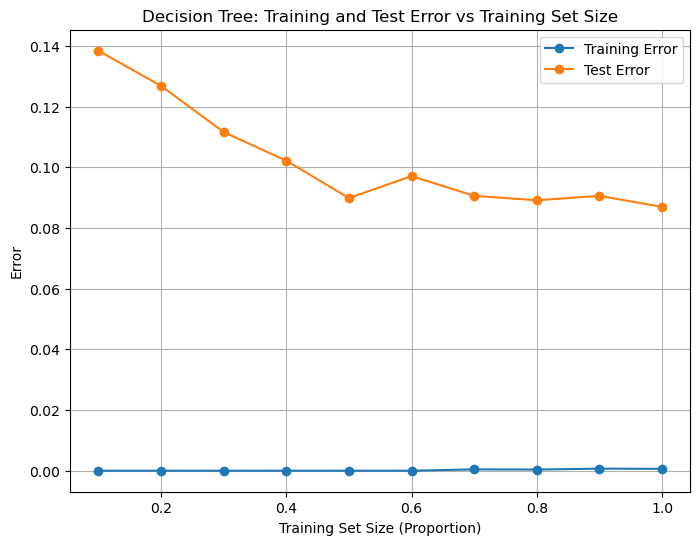

In [69]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Split dataset into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vary training set size
training_sizes = np.linspace(0.1, 1.0, 10)  # 10% to 100% of the training set
train_errors = []
test_errors = []

for size in training_sizes:
    # Sample the training set
    X_train_sample = X_train_full[:int(size * len(X_train_full))]
    y_train_sample = y_train_full[:int(size * len(y_train_full))]
    
    # Train a decision tree
    tree_temp = DecisionTreeClassifier(criterion='gini', random_state=42)
    tree_temp.fit(X_train_sample, y_train_sample)
    tree = reduced_error_pruning(tree_temp,X_train_sample, y_train_sample)
    
    # Evaluate training and test errors
    y_train_pred = tree.predict(X_train_sample)
    y_test_pred = tree.predict(X_test)
    train_errors.append(1 - accuracy_score(y_train_sample, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test, y_test_pred))

# Plot training and test errors
plt.figure(figsize=(8, 6))
plt.plot(training_sizes, train_errors, label='Training Error', marker='o')
plt.plot(training_sizes, test_errors, label='Test Error', marker='o')
plt.title('Decision Tree: Training and Test Error vs Training Set Size')
plt.xlabel('Training Set Size (Proportion)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


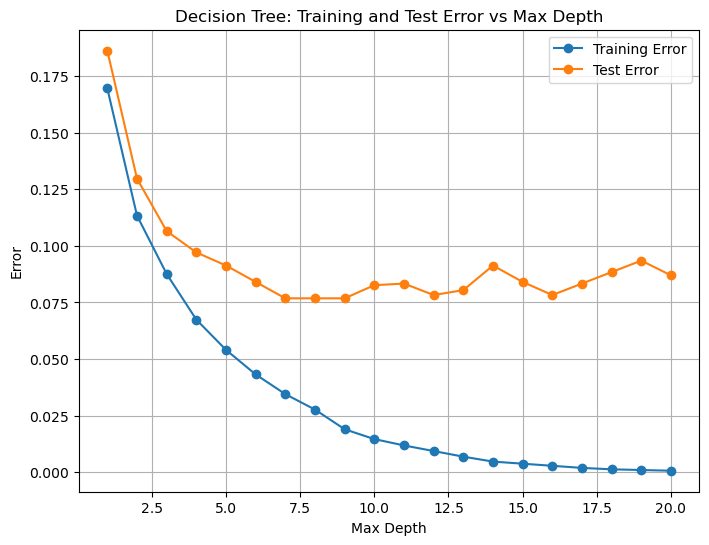

In [77]:
#Experiment with max_depth and criterion for Decision Trees:
# Hyperparameter: max_depth
depths = range(1, 21)  # Test tree depths from 1 to 20
train_errors_depth = []
test_errors_depth = []

for depth in depths:
    tree_temp = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=42)
    tree_temp.fit(X_train_full, y_train_full)
    tree = reduced_error_pruning(tree_temp, X_train_full, y_train_full)
    
    y_train_pred = tree.predict(X_train_full)
    y_test_pred = tree.predict(X_test)
    train_errors_depth.append(1 - accuracy_score(y_train_full, y_train_pred))
    test_errors_depth.append(1 - accuracy_score(y_test, y_test_pred))

# Plot errors for different depths
plt.figure(figsize=(8, 6))
plt.plot(depths, train_errors_depth, label='Training Error', marker='o')
plt.plot(depths, test_errors_depth, label='Test Error', marker='o')
plt.title('Decision Tree: Training and Test Error vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
#Experiment with Gini vs. Entropy:
criterions = ['gini', 'entropy']
for criterion in criterions:
    tree = DecisionTreeClassifier(criterion=criterion, random_state=42)
    tree.fit(X_train_full, y_train_full)
    train_error = 1 - accuracy_score(y_train_full, tree.predict(X_train_full))
    test_error = 1 - accuracy_score(y_test, tree.predict(X_test))
    print(f"{criterion.capitalize()} - Training Error: {train_error:.3f}, Test Error: {test_error:.3f}")


Gini - Training Error: 0.001, Test Error: 0.087
Entropy - Training Error: 0.001, Test Error: 0.085
